In [5]:
from datasets import load_dataset
import pandas as pd
import numpy as np
from datasets import Dataset, DatasetDict, load_from_disk
import os

In [6]:
# set random state for data split
random_state = 1234

# Datasets

### Functions for label cleaning and creating hugging face datasets

#### Function to get rid of duplicate texts with different labels and creating multi-label target (also making sure all labels are lists)
- NOTE: Need to make sure input df has only 2 columns that are named 'text', 'labels'
 
BEFORE:
| text | labels |
|----------|----------|
| "This is duplicate text" | "love" |
| "This is duplicate text" | "joy" |
| "example" | "fear"|

AFTER:
| text | labels |
|----------|----------|
| "This is duplicate text" | ["love", "joy"] |
| "example" | ["fear"]|


In [7]:
# combine duplicate texts with different labels so that it's just one unique text with multilabels
# combine duplicates and non-duplicates df
def to_multilabels_df(df):
    # find duplicates
    dups = df[df.duplicated(subset="text", keep=False)]
    # combine duplicate texts into 1 with multilabels target
    combined_labels_df = dups.groupby('text').agg(lambda x: list(set(x))).reset_index() # avoid duplicate label for the same text using set

    # get duplicate index as list
    dup_ids = dups.index.tolist()
    # get non-duplicates
    non_dups = df[~df.index.isin(dup_ids)]
    # change labels to list for non duplicates
    non_dups.loc[:, 'labels'] = non_dups['labels'].apply(lambda x: [x])

    # combine duplicates and non-duplicates in to 1 df
    combined_df = pd.concat([non_dups, combined_labels_df], ignore_index=True)

    return combined_df 

#### Function to change list of string labels to numerical (id) labels

Example sentiment labels/id:
| labels | id |
|----------|----------|
| "love" | 0 |
| "joy" | 1 |
| "sad" | 2 |
| "fear" | 3 |

BEFORE:
| text | labels |
|----------|----------|
| "This is duplicate text" | ["love", "joy"] |
| "example" | ["fear"]|

AFTER:
| text | labels |
|----------|----------|
| "This is duplicate text" | [0, 1] |
| "example" | [3]|

In [8]:
# convert list of labels to list of ids
def convert2id(label2id, label_list):
    return [label2id[label] for label in label_list]

#### Function to One-Hot-Encod (OHE) numerical/id labels (based on 28 GoEmotions labels)

For this example, assume there's 10 labels

Before:
| text | labels |
|----------|----------|
| "This is duplicate text" | [0, 1] |
| "example" | [3]|

After:
| text | labels |
|----------|----------|
| "This is duplicate text" | [<span style="color: green;">1</span>, <span style="color: green;">1</span>, 0, 0, 0, 0, 0, 0, 0, 0] |
| "example" | [0, 0, 0, <span style="color: green;">1</span>, 0, 0, 0, 0, 0, 0]|

In [9]:
def ohe(labels, num_labels):
    ohe_arr = np.zeros(num_labels, dtype=int)
    for label in labels:
        ohe_arr[label] = 1
    
    return ohe_arr

#### Function to convert pandas df to hugging face df and splitting dataset into train/val/test.
  - 4 cases are considered: 
    - only 1 (training) dataset present (no val/test) --> train split into train/val/test (80/20/20)
    - train/test present (no val) --> train split into train/val
    - train/valid present (no test) --> val will become test
    - all 3 (train/validation/test) present

In [10]:
# convert to huggingface dataset into 3 splits (train/val/test)
def split_convert2hf_dataset(train, val=None, test=None, random_state=1):
    # if train and val passed (no test), val becomes test
    if val is not None and test is None:
        test = val
        val = None

    train_hf_df = Dataset.from_pandas(train)

    # if there's test dataset
    if test is not None:
        test_hf_df = Dataset.from_pandas(test)

    # if there's no validation set
    if val is None:
        # 80% train, 20% test + val
        train_valtest = train_hf_df.train_test_split(test_size=0.2, seed=random_state)

        train_hf_df = train_valtest['train']
        val_hf_df = train_valtest["test"]

        # if no validation and test sets
        if test is None:
            # Split the 20% test + val in half val, half test
            val_test = train_valtest["test"].train_test_split(test_size=0.5, seed=random_state)

            val_hf_df = val_test["train"]
            test_hf_df = val_test["test"]
    else:
        # if val and test datasets provided
        val_hf_df = Dataset.from_pandas(val)
        test_hf_df = Dataset.from_pandas(test)


    return DatasetDict({
    'train': train_hf_df,
    'validation': val_hf_df,
    'test': test_hf_df
    })

#### Function to save processed Hugging Face dataset to disk

In [11]:
# function to save hf dataset on disk
def save_hf_dataset(file_path, dataset):
    # only save when file doesn't exist
    if not os.path.exists(file_path):
        dataset.save_to_disk(file_path)
    else:
        print("Dataset already exists.")

## Process datasets

### GoEmotions

In [12]:
goEmotions = load_dataset("google-research-datasets/go_emotions")
goEmotions

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5427
    })
})

In [13]:
goEmotions["train"][:5]

{'text': ["My favourite food is anything I didn't have to cook myself.",
  'Now if he does off himself, everyone will think hes having a laugh screwing with people instead of actually dead',
  'WHY THE FUCK IS BAYLESS ISOING',
  'To make her feel threatened',
  'Dirty Southern Wankers'],
 'labels': [[27], [27], [2], [14], [3]],
 'id': ['eebbqej', 'ed00q6i', 'eezlygj', 'ed7ypvh', 'ed0bdzj']}

In [14]:
# label2id, id2label
go_id2label = {}
go_label2id = {}
go_labels = goEmotions['train'].features['labels'].feature.names
num_go_labels = len(go_labels)

for idx, label in enumerate(go_labels):
    go_id2label[idx] = label
    go_label2id[label] = idx

go_id2label, go_label2id

({0: 'admiration',
  1: 'amusement',
  2: 'anger',
  3: 'annoyance',
  4: 'approval',
  5: 'caring',
  6: 'confusion',
  7: 'curiosity',
  8: 'desire',
  9: 'disappointment',
  10: 'disapproval',
  11: 'disgust',
  12: 'embarrassment',
  13: 'excitement',
  14: 'fear',
  15: 'gratitude',
  16: 'grief',
  17: 'joy',
  18: 'love',
  19: 'nervousness',
  20: 'optimism',
  21: 'pride',
  22: 'realization',
  23: 'relief',
  24: 'remorse',
  25: 'sadness',
  26: 'surprise',
  27: 'neutral'},
 {'admiration': 0,
  'amusement': 1,
  'anger': 2,
  'annoyance': 3,
  'approval': 4,
  'caring': 5,
  'confusion': 6,
  'curiosity': 7,
  'desire': 8,
  'disappointment': 9,
  'disapproval': 10,
  'disgust': 11,
  'embarrassment': 12,
  'excitement': 13,
  'fear': 14,
  'gratitude': 15,
  'grief': 16,
  'joy': 17,
  'love': 18,
  'nervousness': 19,
  'optimism': 20,
  'pride': 21,
  'realization': 22,
  'relief': 23,
  'remorse': 24,
  'sadness': 25,
  'surprise': 26,
  'neutral': 27})

In [15]:
# drop id column
goEmotions = goEmotions.remove_columns(['id'])
goEmotions

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 5427
    })
})

In [16]:
num_go_labels

28

In [17]:
goEmotions["train"]['labels'][:10]

[[27], [27], [2], [14], [3], [26], [15], [8, 20], [0], [27]]

In [18]:
goEmotionsOhe = goEmotions.map(lambda x: {"labels": ohe(x["labels"], num_go_labels)})
goEmotionsOhe

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 5427
    })
})

In [19]:
display(goEmotions["train"]['labels'][7])
str(goEmotionsOhe['train']['labels'][7])

[8, 20]

'[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]'

In [20]:
# save to disk
file_name = 'goEmotions_cleaned'
file_path = f'./datasets/cleaned_hf/{file_name}'
save_hf_dataset(file_path, goEmotionsOhe)

Dataset already exists.


### SemEvalWorkshop English

In [21]:
semEval = load_dataset("SemEvalWorkshop/sem_eval_2018_task_1", 'subtask5.english', trust_remote_code=True)
semEval

DatasetDict({
    train: Dataset({
        features: ['ID', 'Tweet', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'],
        num_rows: 6838
    })
    test: Dataset({
        features: ['ID', 'Tweet', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'],
        num_rows: 3259
    })
    validation: Dataset({
        features: ['ID', 'Tweet', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'],
        num_rows: 886
    })
})

In [22]:
semEval['train'][0]

{'ID': '2017-En-21441',
 'Tweet': "“Worry is a down payment on a problem you may never have'. \xa0Joyce Meyer.  #motivation #leadership #worry",
 'anger': False,
 'anticipation': True,
 'disgust': False,
 'fear': False,
 'joy': False,
 'love': False,
 'optimism': True,
 'pessimism': False,
 'sadness': False,
 'surprise': False,
 'trust': True}

In [23]:
semEval_emotions = ["anger", "anticipation", "disgust", "fear", "joy", "love", "optimism", "pessimism", "sadness", "surprise", "trust"]

# emotions in goEmotions
in_goEmo = []
# emotions not in goEmotions
not_in_goEmo = []
for emo in semEval_emotions:
    if emo in go_labels:
        in_goEmo.append(emo)
    else:
        not_in_goEmo.append(emo)

print("Emotions in GoEmotions:", in_goEmo)
print("Emotions not in GoEmotions:", not_in_goEmo)

Emotions in GoEmotions: ['anger', 'disgust', 'fear', 'joy', 'love', 'optimism', 'sadness', 'surprise']
Emotions not in GoEmotions: ['anticipation', 'pessimism', 'trust']


In [24]:
# get rid of columns not being used and rename 
remove_cols = not_in_goEmo + ["ID"]

semEval = semEval.remove_columns(remove_cols).rename_column("Tweet", "text")
semEval

DatasetDict({
    train: Dataset({
        features: ['text', 'anger', 'disgust', 'fear', 'joy', 'love', 'optimism', 'sadness', 'surprise'],
        num_rows: 6838
    })
    test: Dataset({
        features: ['text', 'anger', 'disgust', 'fear', 'joy', 'love', 'optimism', 'sadness', 'surprise'],
        num_rows: 3259
    })
    validation: Dataset({
        features: ['text', 'anger', 'disgust', 'fear', 'joy', 'love', 'optimism', 'sadness', 'surprise'],
        num_rows: 886
    })
})

In [25]:
semEval['train'][2]

{'text': "@Max_Kellerman  it also helps that the majority of NFL coaching is inept. Some of Bill O'Brien's play calling was wow, ! #GOPATS",
 'anger': True,
 'disgust': True,
 'fear': False,
 'joy': True,
 'love': False,
 'optimism': True,
 'sadness': False,
 'surprise': False}

In [26]:
# get only True values from each emotion column
def get_emotions(row):
    emotions = [col for col in row.keys() if col != 'text' and row[col] == True]

    return emotions

In [27]:
# create new column 'labels'
semEval_new = semEval.map(lambda row: {'labels': get_emotions(row)})
semEval_new

DatasetDict({
    train: Dataset({
        features: ['text', 'anger', 'disgust', 'fear', 'joy', 'love', 'optimism', 'sadness', 'surprise', 'labels'],
        num_rows: 6838
    })
    test: Dataset({
        features: ['text', 'anger', 'disgust', 'fear', 'joy', 'love', 'optimism', 'sadness', 'surprise', 'labels'],
        num_rows: 3259
    })
    validation: Dataset({
        features: ['text', 'anger', 'disgust', 'fear', 'joy', 'love', 'optimism', 'sadness', 'surprise', 'labels'],
        num_rows: 886
    })
})

In [28]:
# remove original sentiment columns
semEval_new = semEval_new.remove_columns(in_goEmo)
semEval_new

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 6838
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 3259
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 886
    })
})

In [29]:
# convert to pandas for more cleaning (do it for train/val/test)
# 1. some labels are empty arrays --> get rid of these examples
# 2. check for duplicates
semEval_train = semEval_new['train'].to_pandas()
semEval_val = semEval_new['validation'].to_pandas()
semEval_test = semEval_new['test'].to_pandas()

In [30]:
# get rid of empty labels
semEval_train = semEval_train[semEval_train['labels'].apply(lambda x: len(x) > 0)]
semEval_val = semEval_val[semEval_val['labels'].apply(lambda x: len(x) > 0)]
semEval_test = semEval_test[semEval_test['labels'].apply(lambda x: len(x) > 0)]

In [31]:
# check for duplicate text
display(semEval_train[semEval_train.duplicated(subset=['text'], keep=False)])
display(semEval_val[semEval_val.duplicated(subset=['text'], keep=False)])
semEval_test[semEval_test.duplicated(subset=['text'], keep=False)]

# no duplicates found

,text,labels


,text,labels


,text,labels


In [32]:
semEval_train

,text,labels
0,“Worry is a down payment on a problem you may ...,[optimism]
1,Whatever you decide to do make sure it makes y...,"[joy, love, optimism]"
2,@Max_Kellerman it also helps that the majorit...,"[anger, disgust, joy, optimism]"
3,Accept the challenges so that you can literall...,"[joy, optimism]"
4,My roommate: it's okay that we can't spell bec...,"[anger, disgust]"
...,...,...
6831,.@Travelanswerman: The possibilities R endless...,"[joy, optimism]"
6832,You have a #problem? Yes! Can you do #somethin...,"[anger, disgust]"
6834,@andreamitchell said @berniesanders not only d...,[surprise]
6835,@isthataspider @dhodgs i will fight this guy! ...,"[anger, disgust]"


In [33]:
# convert string labels to ids
semEval_train['labels'] = semEval_train['labels'].apply(lambda labels_list: convert2id(go_label2id, labels_list))
semEval_val['labels'] = semEval_val['labels'].apply(lambda labels_list: convert2id(go_label2id, labels_list))
semEval_test['labels'] = semEval_test['labels'].apply(lambda labels_list: convert2id(go_label2id, labels_list))

In [34]:
# reseting index so that dataset doesn't get extra column named '__index_level_0__' when converting to hf df
semEval_train = semEval_train.reset_index(drop=True)
semEval_val = semEval_val.reset_index(drop=True)
semEval_test = semEval_test.reset_index(drop=True)

In [35]:
semEval_train

,text,labels
0,“Worry is a down payment on a problem you may ...,[20]
1,Whatever you decide to do make sure it makes y...,"[17, 18, 20]"
2,@Max_Kellerman it also helps that the majorit...,"[2, 11, 17, 20]"
3,Accept the challenges so that you can literall...,"[17, 20]"
4,My roommate: it's okay that we can't spell bec...,"[2, 11]"
...,...,...
6534,.@Travelanswerman: The possibilities R endless...,"[17, 20]"
6535,You have a #problem? Yes! Can you do #somethin...,"[2, 11]"
6536,@andreamitchell said @berniesanders not only d...,[26]
6537,@isthataspider @dhodgs i will fight this guy! ...,"[2, 11]"


In [36]:
# convert pandas df back to hf df
semEval_hf = split_convert2hf_dataset(semEval_train, semEval_val, semEval_test, random_state)
semEval_hf

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 6539
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 865
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 3156
    })
})

In [37]:
# change labels to ohe
semEval_hf_ohe = semEval_hf.map(lambda x: {"labels": ohe(x["labels"], num_go_labels)})
semEval_hf_ohe

Map:   0%|          | 0/6539 [00:00<?, ? examples/s]

Map:   0%|          | 0/865 [00:00<?, ? examples/s]

Map:   0%|          | 0/3156 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 6539
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 865
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 3156
    })
})

In [38]:
display(semEval_hf["train"][2]['labels'])
str(semEval_hf_ohe["train"][2]['labels'])

[2, 11, 17, 20]

'[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]'

In [39]:
# save to disk
file_name = 'semEval_hf'
file_path = f'./datasets/cleaned_hf/{file_name}'
save_hf_dataset(file_path, semEval_hf_ohe)

Dataset already exists.


### pashupatigupta twitter

In [40]:
pash = pd.read_csv('./datasets/pashupatigupta_emotions_twitter.csv')
pash

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...
...,...,...,...
39995,1753918954,neutral,@JohnLloydTaylor
39996,1753919001,love,Happy Mothers Day All my love
39997,1753919005,love,Happy Mother's Day to all the mommies out ther...
39998,1753919043,happiness,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...


In [41]:
# rename column: content -> text
pash = pash.rename(columns={'sentiment': 'labels', 'content': 'text'})
pash = pash.drop('tweet_id', axis=1)
pash

,labels,text
0,empty,@tiffanylue i know i was listenin to bad habi...
1,sadness,Layin n bed with a headache ughhhh...waitin o...
2,sadness,Funeral ceremony...gloomy friday...
3,enthusiasm,wants to hang out with friends SOON!
4,neutral,@dannycastillo We want to trade with someone w...
...,...,...
39995,neutral,@JohnLloydTaylor
39996,love,Happy Mothers Day All my love
39997,love,Happy Mother's Day to all the mommies out ther...
39998,happiness,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...


In [42]:
pash['labels'].unique().tolist()

['empty',
 'sadness',
 'enthusiasm',
 'neutral',
 'worry',
 'surprise',
 'love',
 'fun',
 'hate',
 'happiness',
 'boredom',
 'relief',
 'anger']

In [43]:
# get emotions only in goemotions labels (disregard others)
pash_redu = pash[pash["labels"].isin(go_labels)]
pash_redu

,labels,text
1,sadness,Layin n bed with a headache ughhhh...waitin o...
2,sadness,Funeral ceremony...gloomy friday...
4,neutral,@dannycastillo We want to trade with someone w...
6,sadness,"I should be sleep, but im not! thinking about ..."
8,sadness,@charviray Charlene my love. I miss you
...,...,...
39993,neutral,"@sendsome2me haha, yeah. Twitter has many uses..."
39995,neutral,@JohnLloydTaylor
39996,love,Happy Mothers Day All my love
39997,love,Happy Mother's Day to all the mommies out ther...


In [44]:
pash_redu_labels = pash_redu['labels'].unique().tolist()
pash_redu_labels

['sadness', 'neutral', 'surprise', 'love', 'relief', 'anger']

In [45]:
pash_cleaned = to_multilabels_df(pash_redu)
pash_cleaned

,labels,text
0,[sadness],Layin n bed with a headache ughhhh...waitin o...
1,[sadness],Funeral ceremony...gloomy friday...
2,[neutral],@dannycastillo We want to trade with someone w...
3,[sadness],"I should be sleep, but im not! thinking about ..."
4,[sadness],@charviray Charlene my love. I miss you
...,...,...
21368,"[sadness, surprise]",my tummy hurts
21369,[sadness],not feeling too great today
21370,[neutral],nothing
21371,"[sadness, surprise]",we're getting another puppy ... not cool... r...


In [46]:
# swap columns
pash_cleaned = pash_cleaned[['text', 'labels']]

In [47]:
# change labels to ids
pash_cleaned['labels'] = pash_cleaned['labels'].apply(lambda labels_list: convert2id(go_label2id, labels_list))
pash_cleaned

,text,labels
0,Layin n bed with a headache ughhhh...waitin o...,[25]
1,Funeral ceremony...gloomy friday...,[25]
2,@dannycastillo We want to trade with someone w...,[27]
3,"I should be sleep, but im not! thinking about ...",[25]
4,@charviray Charlene my love. I miss you,[25]
...,...,...
21368,my tummy hurts,"[25, 26]"
21369,not feeling too great today,[25]
21370,nothing,[27]
21371,we're getting another puppy ... not cool... r...,"[25, 26]"


In [48]:
# split dataset and convert 2 hf df
pash_hf = split_convert2hf_dataset(pash_cleaned, random_state=random_state)
pash_hf

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 17098
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 2137
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 2138
    })
})

In [49]:
# OHE id labels
pash_hf_ohe = pash_hf.map(lambda x: {"labels": ohe(x["labels"], num_go_labels)})
pash_hf_ohe

Map:   0%|          | 0/17098 [00:00<?, ? examples/s]

Map:   0%|          | 0/2137 [00:00<?, ? examples/s]

Map:   0%|          | 0/2138 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 17098
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 2137
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 2138
    })
})

In [50]:
display(pash_hf["train"]['labels'][10])
str(pash_hf_ohe['train']['labels'][10])

[25]

'[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]'

In [51]:
# save to disk
file_name = 'pash_hf'
file_path = f'./datasets/cleaned_hf/{file_name}'
save_hf_dataset(file_path, pash_hf_ohe)

Dataset already exists.


### praveengovi

In [52]:
prav_train = pd.read_csv('./datasets/praveengovi_emotion/train.txt', delimiter=';', header=None, names=['text', 'labels'])
prav_val = pd.read_csv('./datasets/praveengovi_emotion/val.txt', delimiter=';', header=None, names=['text', 'labels'])
prav_test = pd.read_csv('./datasets/praveengovi_emotion/test.txt', delimiter=';', header=None, names=['text', 'labels'])

prav_train, prav_val, prav_test

(                                                    text   labels
 0                                i didnt feel humiliated  sadness
 1      i can go from feeling so hopeless to so damned...  sadness
 2       im grabbing a minute to post i feel greedy wrong    anger
 3      i am ever feeling nostalgic about the fireplac...     love
 4                                   i am feeling grouchy    anger
 ...                                                  ...      ...
 15995  i just had a very brief time in the beanbag an...  sadness
 15996  i am now turning and i feel pathetic that i am...  sadness
 15997                     i feel strong and good overall      joy
 15998  i feel like this was such a rude comment and i...    anger
 15999  i know a lot but i feel so stupid because i ca...  sadness
 
 [16000 rows x 2 columns],
                                                    text   labels
 0     im feeling quite sad and sorry for myself but ...  sadness
 1     i feel like i am still looki

In [53]:
# check if the labels in prav dataset is also in GoEmotions labels
prav_labels = prav_train["labels"].unique().tolist()
display(prav_labels)

print("All emotion labels in prav dataset are in GoEmotions labels:", all([prav_label in go_labels for prav_label in prav_labels]))

['sadness', 'anger', 'love', 'surprise', 'fear', 'joy']

All emotion labels in prav dataset are in GoEmotions labels: True


In [54]:
prav_train_clean = to_multilabels_df(prav_train)
prav_val_clean = to_multilabels_df(prav_val)
prav_test_clean = to_multilabels_df(prav_test)

prav_train_clean

,text,labels
0,i didnt feel humiliated,[sadness]
1,i can go from feeling so hopeless to so damned...,[sadness]
2,im grabbing a minute to post i feel greedy wrong,[anger]
3,i am ever feeling nostalgic about the fireplac...,[love]
4,i am feeling grouchy,[anger]
...,...,...
15964,i was so stubborn and that it took you getting...,"[love, joy]"
15965,i will feel as though i am accepted by as well...,"[love, joy]"
15966,i write these words i feel sweet baby kicks fr...,"[joy, love]"
15967,im still not sure why reilly feels the need to...,"[fear, surprise]"


In [55]:
# change labels to numbers/ids
prav_train_clean['labels'] = prav_train_clean['labels'].apply(lambda labels_list: convert2id(go_label2id, labels_list))
prav_val_clean['labels'] = prav_val_clean['labels'].apply(lambda labels_list: convert2id(go_label2id, labels_list))
prav_test_clean['labels'] = prav_test_clean['labels'].apply(lambda labels_list: convert2id(go_label2id, labels_list))

In [56]:
prav_train_clean

,text,labels
0,i didnt feel humiliated,[25]
1,i can go from feeling so hopeless to so damned...,[25]
2,im grabbing a minute to post i feel greedy wrong,[2]
3,i am ever feeling nostalgic about the fireplac...,[18]
4,i am feeling grouchy,[2]
...,...,...
15964,i was so stubborn and that it took you getting...,"[18, 17]"
15965,i will feel as though i am accepted by as well...,"[18, 17]"
15966,i write these words i feel sweet baby kicks fr...,"[17, 18]"
15967,im still not sure why reilly feels the need to...,"[14, 26]"


In [57]:
prav_hf = split_convert2hf_dataset(prav_train_clean, prav_val_clean, prav_test_clean, random_state)
prav_hf

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 15969
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 1998
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 2000
    })
})

In [58]:
# change labels to ohe
prav_hf_ohe = prav_hf.map(lambda x: {"labels": ohe(x["labels"], num_go_labels)})
prav_hf_ohe

Map:   0%|          | 0/15969 [00:00<?, ? examples/s]

Map:   0%|          | 0/1998 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 15969
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 1998
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 2000
    })
})

In [59]:
display(prav_hf['train'][15967]['labels'])
str(prav_hf_ohe['train'][15967]['labels'])

[14, 26]

'[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]'

In [60]:
# save to disk
file_name = 'prav_hf'
file_path = f'./datasets/cleaned_hf/{file_name}'
save_hf_dataset(file_path, prav_hf_ohe)

Dataset already exists.


## Combine HF Datasets

### Load processed hf datasets

In [61]:
go_hf_processed = load_from_disk('./datasets/cleaned_hf/goEmotions_cleaned')
pash_hf_processed = load_from_disk('./datasets/cleaned_hf/pash_hf')
prav_hf_processed = load_from_disk('./datasets/cleaned_hf/prav_hf')
semEval_hf_processed = load_from_disk('./datasets/cleaned_hf/semEval_hf')

### Merge hf datasets

In [62]:
from datasets import concatenate_datasets, Features, Sequence, Value

In [63]:
go_hf_processed['train'].features

{'text': Value(dtype='string', id=None),
 'labels': Sequence(feature=ClassLabel(names=['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral'], id=None), length=-1, id=None)}

In [64]:
# Need to have the same key labels; change goemotions ClassLabel to Sequence(feature=Value(dtype='int64'))
new_features = Features({
"text": go_hf_processed['train'].features["text"],  # Keep the text 
"labels": Sequence(Value(dtype="int64")) # change
})

go_hf_processed = go_hf_processed.cast(new_features)

In [65]:
print(go_hf_processed['train'].features)
print(go_hf_processed['validation'].features)
print(go_hf_processed['test'].features)

{'text': Value(dtype='string', id=None), 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}
{'text': Value(dtype='string', id=None), 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}
{'text': Value(dtype='string', id=None), 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}


In [66]:
# train
merged_train = concatenate_datasets([go_hf_processed['train'], prav_hf_processed['train'], pash_hf_processed['train'], semEval_hf_processed['train']])
# validation
merged_val = concatenate_datasets([go_hf_processed['validation'], prav_hf_processed['validation'], pash_hf_processed['validation'], semEval_hf_processed['validation']])
# test
merged_test = concatenate_datasets([go_hf_processed['test'], prav_hf_processed['test'], pash_hf_processed['test'], semEval_hf_processed['test']])

In [67]:
# check if adding individual dataset length == merged length
print(len(go_hf_processed['train']) + len(prav_hf_processed['train']) + len(pash_hf_processed['train']) + len(semEval_hf_processed['train']) == len(merged_train))
print(len(go_hf_processed['validation']) + len(prav_hf_processed['validation']) + len(pash_hf_processed['validation']) + len(semEval_hf_processed['validation']) == len(merged_val))
print(len(go_hf_processed['test']) + len(prav_hf_processed['test']) + len(pash_hf_processed['test']) + len(semEval_hf_processed['test']) == len(merged_test))

True
True
True


In [68]:
# Combine train, validation, and test splits into a single DatasetDict
merged_dataset = DatasetDict({
    "train": merged_train,
    "validation": merged_val,
    "test": merged_test
})
merged_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 83016
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 10426
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 12721
    })
})

In [69]:
# save the new merged dataset to disk
file_name = 'merged_hf'
file_path = f'./datasets/cleaned_hf/{file_name}'
save_hf_dataset(file_path, merged_dataset)

Dataset already exists.


## Data Exploration

https://research.google/blog/goemotions-a-dataset-for-fine-grained-emotion-classification/

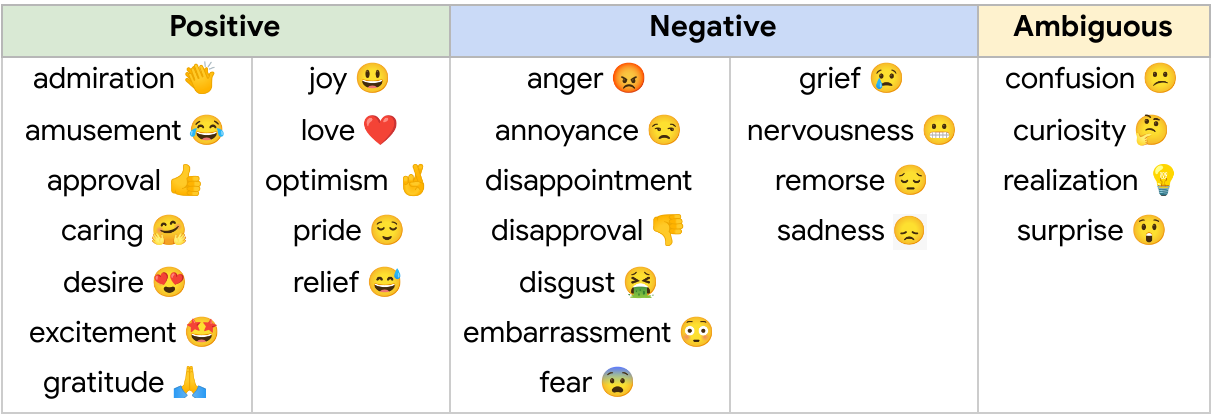

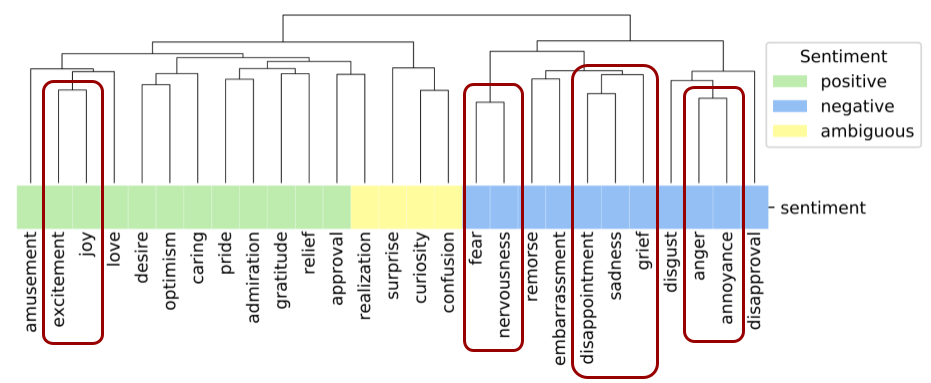

In [70]:
dataset = load_from_disk("./datasets/cleaned_hf/merged_hf")

In [71]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 83016
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 10426
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 12721
    })
})

In [72]:
dataset['train'][0]

{'text': "My favourite food is anything I didn't have to cook myself.",
 'labels': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1]}

# Display frequency of each emotion

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

In [74]:
# combine train/validation/test
train_df = dataset['train'].to_pandas()
val_df = dataset['validation'].to_pandas()
test_df = dataset['test'].to_pandas()

combined_df = pd.concat([train_df, val_df, test_df], ignore_index=True)
display(len(combined_df))
combined_df.head()

106163

,text,labels
0,My favourite food is anything I didn't have to...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"Now if he does off himself, everyone will thin...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,WHY THE FUCK IS BAYLESS ISOING,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,To make her feel threatened,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
4,Dirty Southern Wankers,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [75]:
train_df.shape

(83016, 2)

In [76]:
val_df.shape

(10426, 2)

In [77]:
test_df.shape

(12721, 2)

In [78]:
len(train_df) + len(val_df) + len(test_df)

106163

In [79]:
freq = np.sum(combined_df['labels'], axis=0)
freq

array([ 5122,  2895,  8739,  3093,  3687,  1375,  1673,  2723,   801,
        1583,  2581,  5033,   375,  1052,  4985,  3372,    96, 12864,
        9366,   208,  5410,   142,  1382,  1706,   669, 15815,  4802,
       26389], dtype=int64)

In [80]:
freq_dict = {}
for i, emo in enumerate(go_labels):
    freq_dict[emo] = freq[i]

freq_dict


{'admiration': 5122,
 'amusement': 2895,
 'anger': 8739,
 'annoyance': 3093,
 'approval': 3687,
 'caring': 1375,
 'confusion': 1673,
 'curiosity': 2723,
 'desire': 801,
 'disappointment': 1583,
 'disapproval': 2581,
 'disgust': 5033,
 'embarrassment': 375,
 'excitement': 1052,
 'fear': 4985,
 'gratitude': 3372,
 'grief': 96,
 'joy': 12864,
 'love': 9366,
 'nervousness': 208,
 'optimism': 5410,
 'pride': 142,
 'realization': 1382,
 'relief': 1706,
 'remorse': 669,
 'sadness': 15815,
 'surprise': 4802,
 'neutral': 26389}

In [81]:
# order in desc order
desc_freq = dict(sorted(freq_dict.items(), key=lambda item: item[1], reverse=True))
desc_freq

{'neutral': 26389,
 'sadness': 15815,
 'joy': 12864,
 'love': 9366,
 'anger': 8739,
 'optimism': 5410,
 'admiration': 5122,
 'disgust': 5033,
 'fear': 4985,
 'surprise': 4802,
 'approval': 3687,
 'gratitude': 3372,
 'annoyance': 3093,
 'amusement': 2895,
 'curiosity': 2723,
 'disapproval': 2581,
 'relief': 1706,
 'confusion': 1673,
 'disappointment': 1583,
 'realization': 1382,
 'caring': 1375,
 'excitement': 1052,
 'desire': 801,
 'remorse': 669,
 'embarrassment': 375,
 'nervousness': 208,
 'pride': 142,
 'grief': 96}

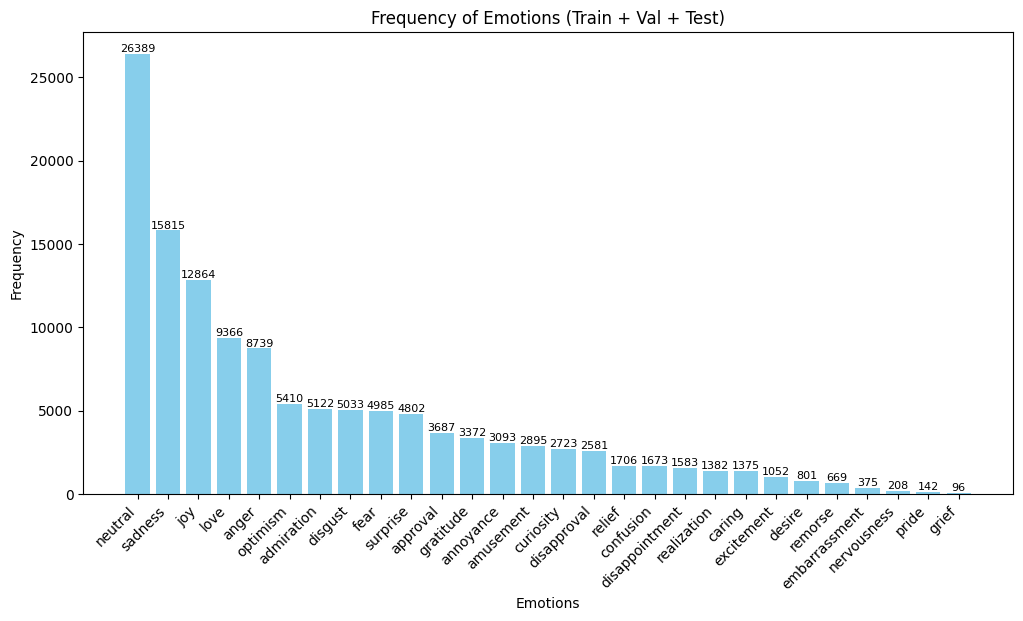

In [82]:
# Plotting the frequency graph
plt.figure(figsize=(12, 6))
bars = plt.bar(desc_freq.keys(), desc_freq.values(), color='skyblue')
plt.xlabel('Emotions')
plt.ylabel('Frequency')
plt.title('Frequency of Emotions (Train + Val + Test)')
plt.xticks(rotation=45, ha='right')
# plt.tight_layout()

# Add frequency numbers on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, int(yval), ha='center', va='bottom', fontsize=8)

plt.show()

In [83]:
print(f"{list(desc_freq.keys())[0]} has {26389 / 96} times more samples than {list(desc_freq.keys())[-1]}")

neutral has 274.8854166666667 times more samples than grief


Original GoEmotions dataset freq graph

In [84]:
goEmotions = load_dataset("google-research-datasets/go_emotions")
goEmotions

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5427
    })
})

In [85]:
# combine train/validation/test
train_orig = goEmotions['train'].to_pandas()
val_orig = goEmotions['validation'].to_pandas()
test_orig = goEmotions['test'].to_pandas()

combined_orig = pd.concat([train_orig, val_orig, test_orig], ignore_index=True)
display(len(combined_orig))
combined_orig.head()

54263

,text,labels,id
0,My favourite food is anything I didn't have to...,[27],eebbqej
1,"Now if he does off himself, everyone will thin...",[27],ed00q6i
2,WHY THE FUCK IS BAYLESS ISOING,[2],eezlygj
3,To make her feel threatened,[14],ed7ypvh
4,Dirty Southern Wankers,[3],ed0bdzj


In [86]:
def show_freq_graph(emotions_list):
    # flatten labels
    all_labels = [label for labels in emotions_list for label in labels]

    # counter for each label
    label_counts = Counter(all_labels)
    
    # order in desc order
    sorted_freq = dict(label_counts.most_common())


    # Plot the frequencies
    plt.figure(figsize=(12, 6))
    bars = plt.bar(sorted_freq.keys(), sorted_freq.values(), color='skyblue')
    plt.xlabel('Label')
    plt.ylabel('Number of examples')
    plt.title('ORIGINAL Label Frequency in GoEmotions Dataset (Train + Valid + Test)')
    plt.xticks(range(len(sorted_freq)), sorted_freq.keys(), rotation=90)  # Rotate labels for readability

    # Add frequency numbers on top of the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, int(yval), ha='center', va='bottom', fontsize=8)

    plt.show()

In [87]:
# change from string labels to ids
labels_str = combined_orig["labels"].apply(lambda label_list: [go_id2label[label] for label in label_list])
labels_str

0           [neutral]
1           [neutral]
2             [anger]
3              [fear]
4         [annoyance]
             ...     
54258     [gratitude]
54259      [approval]
54260       [neutral]
54261    [admiration]
54262       [neutral]
Name: labels, Length: 54263, dtype: object

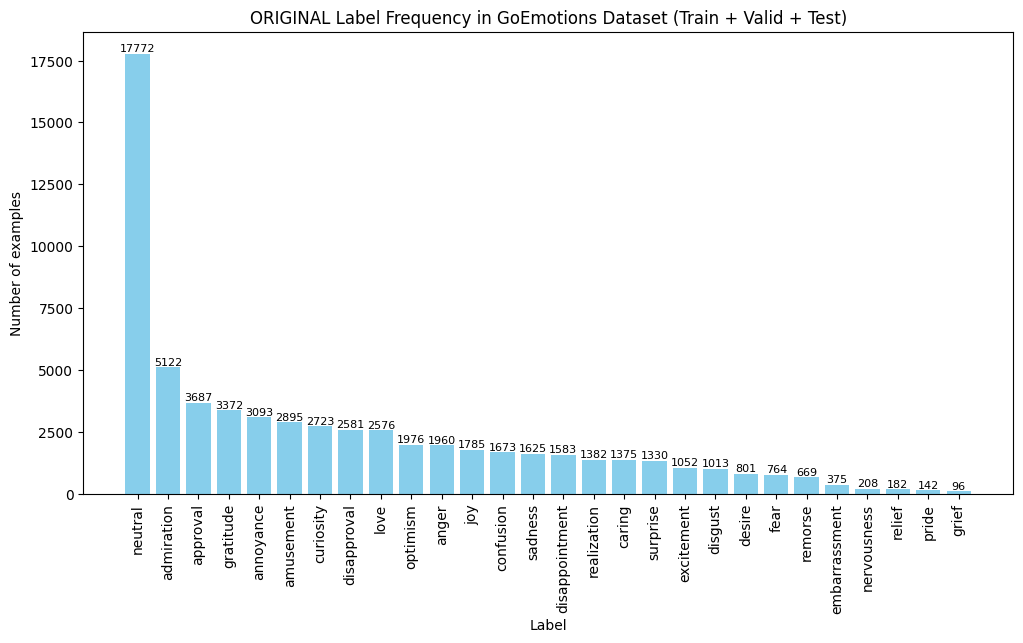

In [88]:
show_freq_graph(labels_str)

Although more data has been added, there's still significant class imbalance due to:
- Other datasets adding onto the majority label ('neutral')
- No/few examples for many minority labels like 'grief' or 'pride'

2 ways to deal with class imbalance:
1. Data Augmentation with TextAttack
2. Class weighting

Notes:
- When using TextAttack, make sure the augmented examples are of good quality or they can lead to too much noise (ex. text can become mean completely different than original if done incorrectly) or/and can hurt model performance (ex. overfit).
- Class weighting: Assign higher importance to minority labels during training. Very useful for (very) imbalanced dataset like this.

# Data Augmentation: TextAttack

https://github.com/QData/TextAttack

`embedding` augments text by replacing words with neighbors in the counter-fitted embedding space, with a constraint to ensure their cosine similarity is at least 0.8

`clare` augments text by replacing, inserting, and merging with a pre-trained masked language model.
- Takes way too long

## See freq graph for train/val/test separately

In [89]:
def create_freq_dict(df, labels, desc=True):
    freq = np.sum(df['labels'], axis=0)
    
    freq_dict = {}
    for i, emo in enumerate(labels):
        freq_dict[emo] = freq[i]

    # if descending order requested
    if desc:
        freq_dict = dict(sorted(freq_dict.items(), key=lambda item: item[1], reverse=True))

    return freq_dict

In [90]:
def plot_freq(freq_dict, df_type):
    """
    freq_dict: frequency dictionary
    df_type: train/val/test
    """

    # Plotting the frequency graph
    plt.figure(figsize=(12, 6))
    bars = plt.bar(freq_dict.keys(), freq_dict.values(), color='skyblue')
    plt.xlabel('Emotions')
    plt.ylabel('Frequency')
    plt.title(f'Frequency of Emotions ({df_type})')
    plt.xticks(rotation=45, ha='right')
    # plt.tight_layout()

    # Add frequency numbers on top of the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, int(yval), ha='center', va='bottom', fontsize=8)

    plt.show()

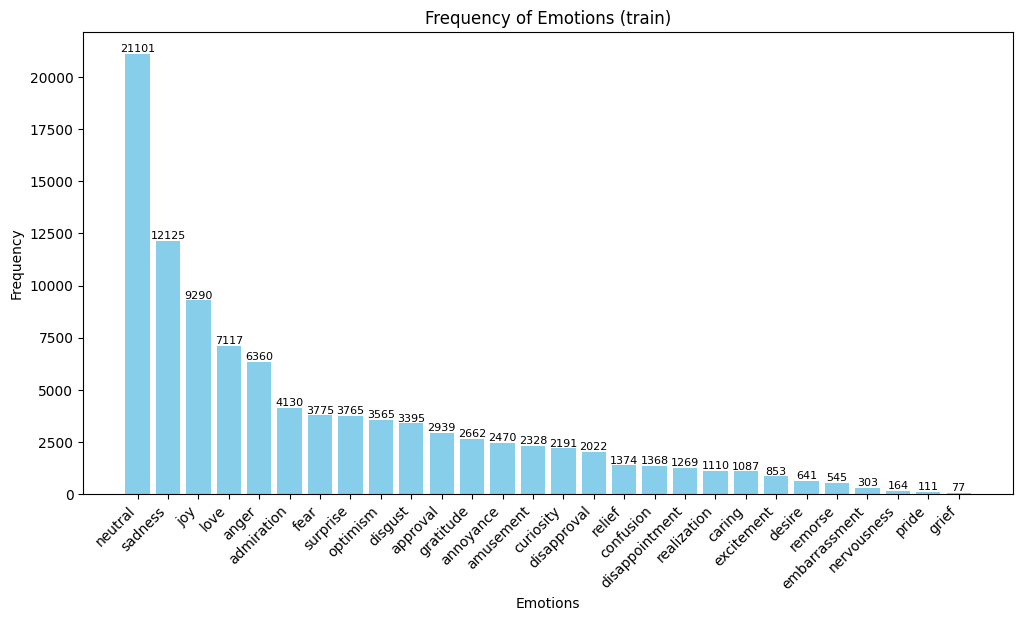

In [91]:
# train
desc_freq = create_freq_dict(train_df, go_labels, desc=True)
plot_freq(desc_freq, "train")

In [113]:
desc_freq = create_freq_dict(train_df, go_labels, desc=True)
desc_freq

{'neutral': 21101,
 'sadness': 12125,
 'joy': 9290,
 'love': 7117,
 'anger': 6360,
 'admiration': 4130,
 'fear': 3775,
 'surprise': 3765,
 'optimism': 3565,
 'disgust': 3395,
 'approval': 2939,
 'gratitude': 2662,
 'annoyance': 2470,
 'amusement': 2328,
 'curiosity': 2191,
 'disapproval': 2022,
 'relief': 1374,
 'confusion': 1368,
 'disappointment': 1269,
 'realization': 1110,
 'caring': 1087,
 'excitement': 853,
 'desire': 641,
 'remorse': 545,
 'embarrassment': 303,
 'nervousness': 164,
 'pride': 111,
 'grief': 77}

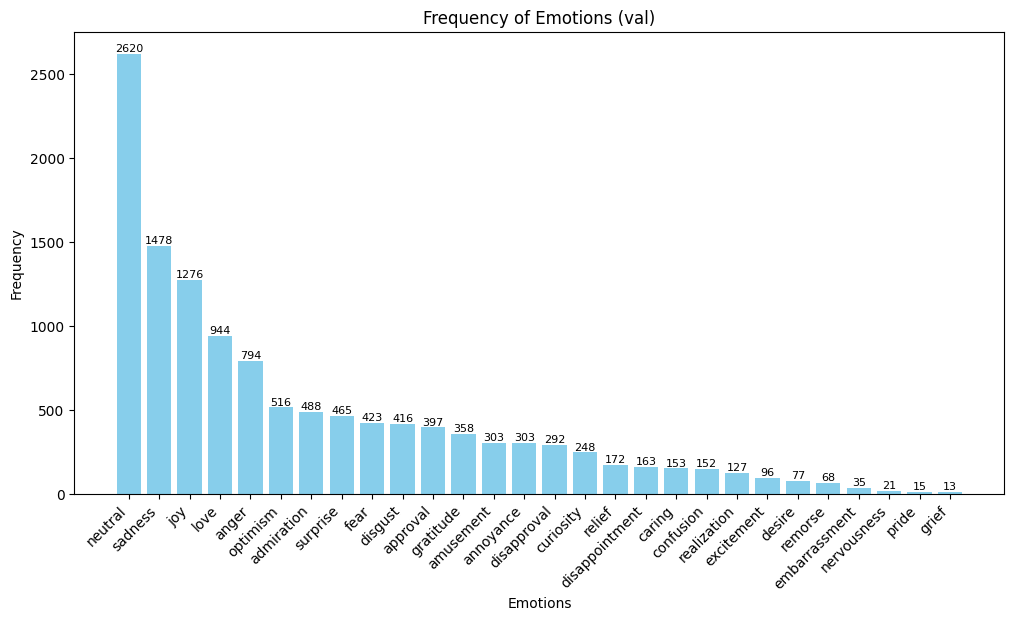

In [92]:
# val
desc_freq = create_freq_dict(val_df, go_labels, desc=True)
plot_freq(desc_freq, "val")

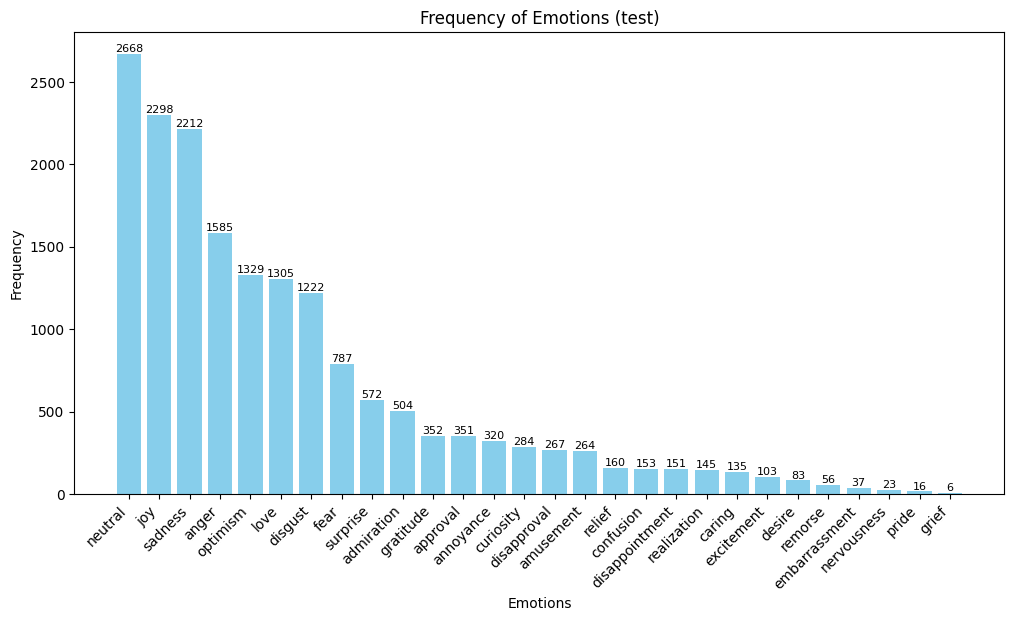

In [93]:
# test
desc_freq = create_freq_dict(test_df, go_labels, desc=True)
plot_freq(desc_freq, "test")

## Data augment training dataset
- Will be creating x1 to x3 original data size for each sentiment

In [94]:
train_df

,text,labels
0,My favourite food is anything I didn't have to...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"Now if he does off himself, everyone will thin...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,WHY THE FUCK IS BAYLESS ISOING,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,To make her feel threatened,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
4,Dirty Southern Wankers,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...
83011,.@Travelanswerman: The possibilities R endless...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
83012,You have a #problem? Yes! Can you do #somethin...,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
83013,@andreamitchell said @berniesanders not only d...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
83014,@isthataspider @dhodgs i will fight this guy! ...,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."


In [ ]:
# # map out sentiments to ohe label
# ohe_labels = {}
# for i, emo in enumerate(go_labels):
#     zeros = np.zeros(28, dtype=int)
#     zeros[i] = 1

#     ohe_labels[emo] = list(zeros)

# for k,v in ohe_labels.items():
#     print(f"{k}: {v}")
#     # print(f"{v}")

In [133]:
train_df[train_df['labels'].apply(lambda x: x[0] != 1 or x[1] != 1 or x[2] != 1 or x[3] != 1 or x[4] != 1 or x[7] != 1 or x[10] != 1 or x[11] != 1 or x[14] != 1 or x[15] != 1 or x[17] != 1 or x[18] != 1 or x[20] != 1 or x[25] != 1 or x[26] != 1 or x[-1] != 1)]

,text,labels
0,My favourite food is anything I didn't have to...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"Now if he does off himself, everyone will thin...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,WHY THE FUCK IS BAYLESS ISOING,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,To make her feel threatened,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
4,Dirty Southern Wankers,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...
83011,.@Travelanswerman: The possibilities R endless...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
83012,You have a #problem? Yes! Can you do #somethin...,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
83013,@andreamitchell said @berniesanders not only d...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
83014,@isthataspider @dhodgs i will fight this guy! ...,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."


In [140]:
def filter_labels(x, exclude_labels):
    for i in range(len(x)):
        if i in exclude_labels and x[i] == 1:
            return False
    return True

In [144]:
# only get labels where labels < 2000 in train freq graph
# relief (23), confusion (6), disappointment (9), realization (22), caring (5), excitement (13), desire (8), remorse (24), embarrassment (12), nervousness (19), pride (21), grief (16)

# freq >= 2000: 0, 1, 2, 3, 4, 7, 10, 11, 14, 15, 17, 18, 20, 25, 26, 27
freq_gte_2000 = [0, 1, 2, 3, 4, 7, 10, 11, 14, 15, 17, 18, 20, 25, 26, 27]

# Filter the dataframe for labels with frequency < 2000
train_df_minority = train_df[train_df['labels'].apply(
    lambda x: filter_labels(x, freq_gte_2000))]

train_df_minority

,text,labels
10,Demographics? I don’t know anybody under 35 wh...,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
13,R/sleeptrain Might be time for some sleep trai...,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
19,Maybe that’s what happened to the great white ...,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
21,i got a bump and a bald spot. i feel dumb <3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
31,"All sounds possible except the key, I can't se...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...
76365,http://twitpic.com/67hw5 - Session almost over,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
76415,@tatianafrosario omg wow I hope everything is...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
76436,@LisaSpangenberg sadly @Dawno isn't me. It's s...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
76454,"@Gernika Had lunch at Bittercreek, they were o...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [176]:
from textattack.augmentation import CLAREAugmenter, EmbeddingAugmenter

In [177]:
augmenter = EmbeddingAugmenter()

In [178]:
# create dataset for each emotion label
def augment_data(df, augmenter): 
    augmented_df = df.copy()

    # augmentation
    augmented_df['text'] = augmented_df['text'].apply(lambda x: augmenter.augment(x)[0])

    return augmented_df

In [182]:
left = -3
augmented_train = augment_data(train_df_minority[left:], augmenter)
augmented_train

,text,labels
76436,@LisaSpangenberg regrettably @Dawno isn't me. ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
76454,"@Gernika Had supper at Bittercreek, they were ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
76463,@khorshid I hope to see you quick again,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [184]:
# compare augmented vs original text
for i, text in enumerate(augmented_train['text'][:3]):
    print("augmented:", text)
    print("original:", train_df_minority['text'][left:].iloc[i])
    print("-------")
    

augmented: @LisaSpangenberg regrettably @Dawno isn't me. It's some1 w/ 1 follower 1 update &amp; hasn't utilizes Twitter since May 1, '07  I wanted that name, too
original: @LisaSpangenberg sadly @Dawno isn't me. It's some1 w/ 1 follower 1 update &amp; hasn't used Twitter since May 1, '07  I wanted that name, too
-------
augmented: @Gernika Had supper at Bittercreek, they were out of Hopnoxious  Had Sweetgrass IPA shou, so all is still right in the world.
original: @Gernika Had lunch at Bittercreek, they were out of Hopnoxious  Had Sweetgrass IPA tho, so all is still right in the world.
-------
augmented: @khorshid I hope to see you quick again
original: @khorshid I hope to see you soon again
-------


In [185]:
# full dataset
augmented_train = augment_data(train_df_minority, augmenter)

Building prefix dict from the default dictionary ...
Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\skpar\AppData\Local\Temp\jieba.cache
Dumping model to file cache C:\Users\skpar\AppData\Local\Temp\jieba.cache
Loading model cost 0.843 seconds.
Loading model cost 0.843 seconds.
Prefix dict has been built successfully.
Prefix dict has been built successfully.


In [187]:
for i, text in enumerate(augmented_train['text']):
    print(i)
    print("augmented:", text)
    print("original:", train_df_minority['text'].iloc[i])
    print("-------")

0
augmented: Demographics? I don’t know anybody under 35 who has cables tv.
original: Demographics? I don’t know anybody under 35 who has cable tv.
-------
1
augmented: R/sleeptrain Probable be time for some sleeping training. Take a look and try to feel out what's right for your family.
original: R/sleeptrain Might be time for some sleep training. Take a look and try to feel out what's right for your family.
-------
2
augmented: Maybe that’s what happened to the great branca at Houston zoo
original: Maybe that’s what happened to the great white at Houston zoo
-------
3
augmented: i got a damper and a bald spot. i feel dumb <3
original: i got a bump and a bald spot. i feel dumb <3
-------
4
augmented: Every sounds possible except the key, I can't see how it was missed in the first search. 
original: All sounds possible except the key, I can't see how it was missed in the first search. 
-------
5
augmented: Quel does FPTP have to do with the referendum?
original: What does FPTP have to 

In [ ]:
# checking if original dataset and augmented dataset have same labels
all(train_df_minority['labels'] == augmented_train['labels'])

True

In [ ]:
# manual checking to see quality of augmented data
# add augmented_train to train_df, not train_df_minority
# shuffle pd dataset

## Add synthetic dataset using ChatGPT
- Although I tried using CLARE in textattack, it took a very time time, possibly due to PC hardware constraints and not using GPU (couldn't figure out if it was using GPU, and if it wasn't, how to change to cuda). 
- I decided to use ChatGPT to add more synthetic examples instead.
  - Mixture of GPT-4o and GPT-4o mini used
  - Synthetic data have been manually reviewed (doesn't mean the texts/labels are perfect)
  - Similar texts are produced but they can be considered as data augmentation as long as they have similar/same labels.

Prompt used:

```python
{'neutral': 21101,
 'sadness': 12125,
 'joy': 9290,
 'love': 7117,
 'anger': 6360,
 'admiration': 4130,
 'fear': 3775,
 'surprise': 3765,
 'optimism': 3565,
 'disgust': 3395,
 'approval': 2939,
 'gratitude': 2662,
 'annoyance': 2470,
 'amusement': 2328,
 'curiosity': 2191,
 'disapproval': 2022,
 'relief': 1374,
 'confusion': 1368,
 'disappointment': 1269,
 'realization': 1110,
 'caring': 1087,
 'excitement': 853,
 'desire': 641,
 'remorse': 545,
 'embarrassment': 303,
 'nervousness': 164,
 'pride': 111,
 'grief': 77}
 ```
> give me 100 examples. This time, based on the frequency of each sentiment, create more examples if there's less frequency. Example can be multilabel. Try avoid using label in the text example. this is not good:
{"text": "The grief of losing someone so close to me is unbearable.", "labels": ['Grief']}

Notes: 
- Inputting the prompt above may not generate expected output. It is just for reference. Make sure to prompt engineering to produce result that you want.
- I noticed that ChatGPT doesn't really listen to instructions sometimes and hallucinate.
  - ex. Told not to include labels in example text but it sometimes ignored the instruction.
  - ex. Didn't give 100 examples
  - ex. Examples with 'grief' not produced as much even though it was instructed to focus on labels with less frequency.
  - ex. created new labels that's not in GoEmotions

Examples were sub-par, so I've decided not to use them.